# Box count example
Load basic packages

In [1]:
import box_count_method as bcm

#import pandas_bokeh
from bokeh.io import output_file, output_notebook
from bokeh.models import Span, Label
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.palettes import linear_palette, Turbo256
#pd.set_option('plotting.backend', 'pandas_bokeh')
output_notebook(hide_banner=True)
from IPython.core.display import display, HTML
import tkinter as tk
from tkinter import filedialog

C:\Users\Florian Kleiner\AppData\Local\Temp\ipykernel_128672\4128006179.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


Change the variable `slice_image` to `False` to open an already prepared folder with multiple image tiles instead of a single large image.

In [2]:
slice_image = True

In [3]:
filepath = filedialog.askopenfilename( title='Please select the reference image', filetypes=[("Tiff images", "*.tif;*.tiff")] )
thresh_values = {  0: 'pores',
                 125: 'CSH',
                 167: 'CH',
                 198: 'alite',
                 }
row_cnt=20
col_cnt=20


## load image and if not already done, preprocess and segment the image

In [4]:
img_loader = bcm.image_loader(filepath, thresh_values, verbose = False )
combined_masks = img_loader.image['seg']
scaling        = img_loader.scaling
file_dir       = img_loader.path
file_extension = img_loader.file_extension
file_name      = img_loader.file_name

D:/GIT/measure_cement_hydrate_fringe/C3S/28d/2019_04_15 FK C3S 28d CT.tif D:/GIT/measure_cement_hydrate_fringe/C3S/28d\
loading 2019_04_15 FK C3S 28d CT_seg.tif
avoid loading 2019_04_15 FK C3S 28d CT_nlm.tif
avoid loading 2019_04_15 FK C3S 28d CT_enh.tif
avoid loading 2019_04_15 FK C3S 28d CT.tif

Area proportions:
  pores: 10.85%
  CSH: 45.15%
  CH: 34.30%
  alite: 9.70%


## slice segmented image in smaller images

   - 2019_04_15 FK C3S 28d CT_0019_0019.tif
   - 2019_04_15 FK C3S 28d CT_0000_0019.tif
   - 2019_04_15 FK C3S 28d CT_0001_0019.tif
   - 2019_04_15 FK C3S 28d CT_0002_0019.tif
   - 2019_04_15 FK C3S 28d CT_0003_0019.tif
   - 2019_04_15 FK C3S 28d CT_0004_0019.tif
   - 2019_04_15 FK C3S 28d CT_0005_0019.tif
   - 2019_04_15 FK C3S 28d CT_0006_0019.tif
   - 2019_04_15 FK C3S 28d CT_0007_0019.tif
   - 2019_04_15 FK C3S 28d CT_0008_0019.tif
   - 2019_04_15 FK C3S 28d CT_0009_0019.tif
   - 2019_04_15 FK C3S 28d CT_0010_0019.tif
   - 2019_04_15 FK C3S 28d CT_0011_0019.tif
   - 2019_04_15 FK C3S 28d CT_0012_0019.tif
   - 2019_04_15 FK C3S 28d CT_0013_0019.tif
   - 2019_04_15 FK C3S 28d CT_0014_0019.tif
   - 2019_04_15 FK C3S 28d CT_0015_0019.tif
   - 2019_04_15 FK C3S 28d CT_0016_0019.tif
   - 2019_04_15 FK C3S 28d CT_0017_0019.tif
   - 2019_04_15 FK C3S 28d CT_0018_0019.tif


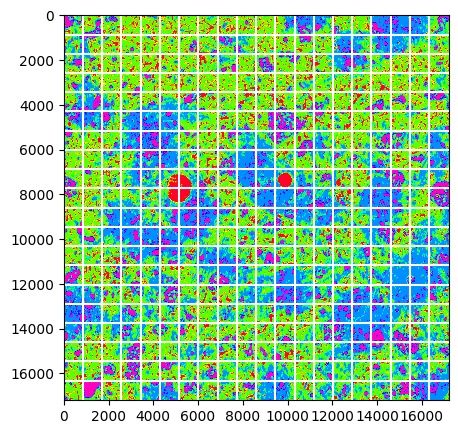

In [5]:
targetDirectory = bcm.sliceImage( file_dir, file_name, combined_masks, row_cnt=row_cnt, col_cnt=col_cnt, show_result = True )

In [6]:
phaseContent = bcm.phaseContent(targetDirectory, list( thresh_values.values() ), verbose=True)

reading CSV "2019_04_15 FK C3S 28d CT_box_count_intermediate.csv"
Loaded 400 images
processing 75 experiments
mean & std deviation of pores
mean & std deviation of CSH
mean & std deviation of CH
mean & std deviation of alite
--------------------


Select the source file(s):
- folder with the segmented images (by color) 
- large segmented image file (by color) 

The large image will be cut to tiles as defined in `x` and `y` values (standard = 10x10).

Furthermore the image tiles will be processed using the `phaseContent` classdefined in the `box_count_method.py`.

basic functions to generate the following diagrams

In [8]:
def getLineDiagram_mean_type(phaseContent, title, plot_width=1200, legend_location='top_right'):
    if phaseContent.scaling['unit'] != 'px':
        _, unit = phaseContent.get_dataset_area(decimal=1)
        tile_area, unit = phaseContent.get_tile_area(in_unit=unit)
    else:
        tile_area = 1
        unit = 'image tiles'
    p = figure(title=title, x_range=(tile_area, phaseContent.image_shuffle_count * tile_area), y_range=(0, 100))#, plot_width=plot_width, plot_height=600
    p.left[0].formatter.use_scientific = False

    p.xaxis.axis_label = 'area in {}'.format( unit )
    p.yaxis.axis_label = 'phase content in %'

    stdev_below = 2
    vertical_pos_max = 0
    vertical_pos_min = phaseContent.image_shuffle_count
    colors = linear_palette(Turbo256,len(phaseContent.phase_names))
    for i in range(phaseContent.phase_count):
        key = 'phase_{:02d}_percent'.format(i)
        stdev = phaseContent.stDev_stDev[key]
        mean = phaseContent.stDev_mean[key]
        
        value_cnt = len(stdev)
        x_range = list(range(value_cnt))
        x_range.pop(0)
        x_range.append(value_cnt)
        x_range = list( map(lambda x: x * tile_area, x_range) )

        positive = list(map(float.__add__, mean, stdev))
        negative = list(map(float.__sub__, mean, stdev))
        
        #phase_names[i]
        p.line(x_range, mean    , line_color=colors[i],                     line_width=2, legend_label=phaseContent.phase_names[i])
        p.line(x_range, positive, line_color=colors[i], line_dash='dashed', line_width=2, legend_label=phaseContent.phase_names[i]+' stdev')
        p.line(x_range, negative, line_color=colors[i], line_dash='dashed', line_width=2)

        for pos in range(len(stdev)):
            if stdev[pos] < stdev_below:
                if vertical_pos_max < pos: vertical_pos_max = pos
                if vertical_pos_min > pos: vertical_pos_min = pos
                break
    
    annotation1 = Span(location=vertical_pos_min*tile_area, dimension='height', line_color='blue', line_dash='dotted', line_width=1)
    annotation2 = Span(location=vertical_pos_max*tile_area, dimension='height', line_color='green', line_dash='dotted', line_width=1)
    #citation = Label(x=5*tile_area, y=80, render_mode='css', text='Standard deviation below {} percent after {:.4f} to {:.4f} {}'.format(stdev_below, vertical_pos_min*tile_area, vertical_pos_max*tile_area, unit) )
    
    p.add_layout( annotation1 )
    p.add_layout( annotation2 )
    #p.add_layout( citation )

    p.legend.location = legend_location
    show(p)

generate Diagrams 

In [9]:
experiments = 300
phaseContent.box_count_method(experiments, verbose=False)
getLineDiagram_mean_type(phaseContent, '{} experiments per image count'.format( experiments ))

# area growth method


Area proportions:
  pores: 11.11%
  CSH: 36.46%
  CH: 43.64%
  alite: 8.79%

Area proportions:
  pores: 11.18%
  CSH: 39.13%
  CH: 39.39%
  alite: 10.30%

Area proportions:
  pores: 11.13%
  CSH: 42.87%
  CH: 36.47%
  alite: 9.53%


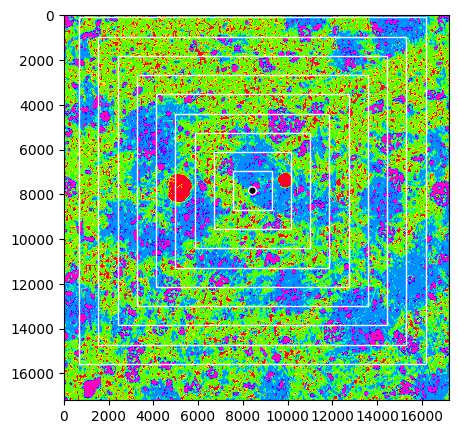

0% done...
1% done...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...


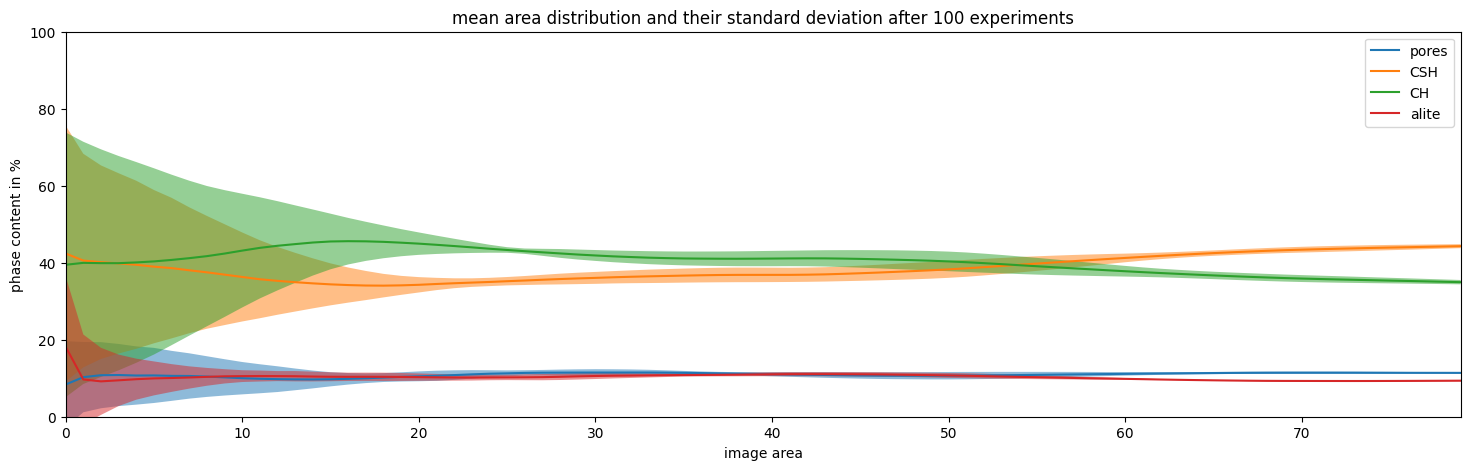

In [10]:
experiments = 100
da = phaseContent.area_growth_method(combined_masks, seed_window_f=5, step_w=1, experiments=experiments, verbose=True)

import matplotlib.pyplot as plt
import pandas as pd
results = {}
fig, ax = plt.subplots( 1, 1, figsize = ( 18, 5 ) )
plt.title("mean area distribution and their standard deviation after {} experiments".format(experiments))
for i, phase in enumerate(phaseContent.phase_names):
    results[phase+'_mean'] = da.mean(dim='experiment').loc[:,i]
    results[phase+'_std']  = da.std( dim='experiment').loc[:,i]
    mean = results[phase+'_mean'] *100
    std  = results[phase+'_std']  *100
    ax.plot( range(len(mean)), mean )
    ax.fill_between(range(len(mean)), mean+std, mean-std, alpha=0.5,label='_nolegend_')
plt.xlim(0,len(mean)-1)
plt.ylim(0,100)
plt.xlabel("image area")
plt.ylabel("phase content in %")
plt.legend( phaseContent.phase_names )
plt.show()
results_df = pd.DataFrame(results)